# Whitebox attack using privacy meter

# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import copy
import random
import os
import time

from torch import nn
from tqdm import tqdm
from ast import List
from torchvision import transforms
from model import Net, CNNMnist, CNNCifar, LeNet, ResNet, ResidualBlock, CNNDrop
from train import nor_train, dp_train, dp_trainv2, proposed_train
from util import sec_func, test
from fed import ProtectWeight, FlatSplitParams, aggregate

random.seed(123)
np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
torch.cuda.manual_seed(123)

/home/wayne/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-07 11:11:28.118926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 11:11:28.600040: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-07 11:11:28.600096: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerr

# Define hyper-parameters

In [2]:
# for training the target model
num_train_points = 500
num_test_points = 500
num_population_points = 1000
batch_size = 64
learning_rate = 0.01
local_epochs = 10
clients = 100
glob_epochs = 100
drop_frac = 0.1

q = 0.9 # sampling rate
eps = 1.0 # privacy budget
delta = 10e-5 # probability of something bad happening
clip = 1.5
# laplace noise: [np.random.laplace(loc=0, scale=1/epsilon) for x in range(100000)]
sensitivity = 2 * learning_rate * clip  / num_train_points
sigma = np.sqrt(2 * np.log(1.25 / (delta/ glob_epochs))) * 1 / (eps/ glob_epochs)
# gaussian noise: vals_gauss = [np.random.normal(loc=0, scale=sigma) for x in range(100000)]
print("sensitivity: ", sensitivity)
print("sigma: ", sigma)
print("sensitivity * sigma: ", sensitivity * sigma)

device = 'cuda' if torch.cuda.is_available() else 'cpu' # you can change it to 'cuda' if you have GPU
rootpath = './log'
mechanism = "DP2"
model_name = 'resnet'

sensitivity:  5.9999999999999995e-05
sigma:  529.8802526850474
sensitivity * sigma:  0.03179281516110284


# Create the data

Load all the data

In [3]:
# transform = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# transform = transforms.Compose([
# #     transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
#     transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
#     transforms.RandomRotation(10),     #Rotates the image to a specified angel
#     transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
#     transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
# #     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
# ])

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])
# transform = transforms.Compose([transforms.ToTensor()])

all_data = torchvision.datasets.CIFAR10(
    root='.', train=True, download=True, transform=transform
)
# test_data = torchvision.datasets.CIFAR10(
#     root='.', train=False, download=True, transform=transform
# )
# all_features = np.concatenate([all_data.data, test_data.data], axis=0)
# all_targets = np.concatenate([all_data.targets, test_data.targets], axis=0)

# all_data.data = all_features
# all_data.targets = all_targets

Files already downloaded and verified


In [4]:
def get_dataset_subset(dataset: torchvision.datasets, index: List(int)):
    """Get a subset of the dataset.

    Args:
        dataset (torchvision.datasets): Whole dataset.
        index (list): List of index.
    """
    assert max(index) < len(dataset) and min(index) >= 0, "Index out of range"
    data = (
        torch.from_numpy(dataset.data[index]).float().permute(0, 3, 1, 2) / 255
    )  # channel first
    targets = list(np.array(dataset.targets)[index])
    targets = torch.tensor(targets, dtype=torch.long)
    return data, targets

Split the data into train, test and population

In [5]:
chosen_index = []
train_data, train_targets, test_data, test_targets, audit_data, audit_targets, train_index, test_index = [], [], [], [], [], [], [], []

all_index = np.arange(len(all_data))
for i in range(clients):
  train_i = np.random.choice([i for i in all_index if i not in chosen_index], num_train_points, replace=False)
  test_i = np.random.choice([i for i in all_index if i not in train_i], num_test_points, replace=False)
  population_index = np.random.choice([i for i in all_index if i not in train_i and i not in test_i], num_population_points, replace=False)
  chosen_index = np.concatenate((chosen_index,train_i))

  train_d, train_t = get_dataset_subset(all_data, train_i)
  test_d, test_t = get_dataset_subset(all_data, test_i)
  audit_d, audit_t = get_dataset_subset(all_data, population_index)
  train_data.insert(i, train_d)
  train_targets.insert(i, train_t)
  test_data.insert(i, test_d)
  test_targets.insert(i, test_t)
  audit_data.insert(i, audit_d)
  audit_targets.insert(i, audit_t)
  train_index.insert(i, train_i)
  test_index.insert(i, test_i)

Create the data loader for training the target model

In [6]:
train_loader, test_loader = [], []
for i in range(clients):
  train_l = torch.utils.data.DataLoader(
              torch.utils.data.Subset(all_data,train_index[i]),
              batch_size=batch_size,
              shuffle=True,
              num_workers=4,
              pin_memory=True,
              persistent_workers=True,
              prefetch_factor=16)
  test_l = torch.utils.data.DataLoader(
              torch.utils.data.Subset(all_data,test_index[i]),
              batch_size=batch_size,
              shuffle=True,
              num_workers=4,
              pin_memory=True,
              persistent_workers=True,
              prefetch_factor=16)
  train_loader.insert(i, train_l)
  test_loader.insert(i, test_l)

In [7]:
transform = transforms.Compose([transforms.ToTensor()])
evl_data = torchvision.datasets.CIFAR10(
    root='.', train=False, download=True, transform=transform
)
evl_index = np.arange(len(evl_data))
# eval_index = np.random.choice([i for i in evl_index], int(num_train_points * 0.25), replace=False)
evl_loader = torch.utils.data.DataLoader(
            #   torch.utils.data.Subset(evl_data,eval_index),
              evl_data,
              batch_size=batch_size,
              shuffle=False,
              num_workers=4,
              pin_memory=True,
              persistent_workers=True,
              prefetch_factor=16)

Files already downloaded and verified


# Train the target model

In [8]:
if model_name == 'resnet':
   glob_model = ResNet(ResidualBlock, [2, 2, 2]) # ResNet18
elif model_name == 'cnn':
   glob_model = CNNCifar()
   # glob_model = CNNDrop()
elif model_name == 'lenet':
   glob_model = LeNet()

all_clients = range(clients)
split_index, flat_indice = FlatSplitParams(copy.deepcopy(glob_model), clients)
lr = [learning_rate] * clients
sec_record, acc_record, loss_record, time_record = [], [], [], []
test_sec_model = copy.deepcopy(glob_model)
criterion = nn.CrossEntropyLoss()

for j in range(glob_epochs):
   drop_users = random.sample(all_clients[1:], int(clients * drop_frac)) # client 0 is used to evaluate security
   nondrop_users = [x for x in range(clients) if x not in drop_users]
   w_locals, weight_slices, noise_slices = [], [], []
   start_time = time.time()
   # print("Global Epoch: ", j, " | Drop clients: ", drop_users)
   for i in tqdm(range(clients), desc=f"Global Epoch: {j} | Drop Num: {len(drop_users)}"):
      if i in drop_users:
         weight_slices.insert(i, "D")
         noise_slices.insert(i, "D")
         continue
      
      if mechanism == 'None':
        w = nor_train(copy.deepcopy(glob_model), device, i, lr, local_epochs, train_loader[i])
      elif mechanism == 'DP':
         w = dp_train(copy.deepcopy(glob_model), device, i, lr, local_epochs, batch_size, train_loader[i], test_loader[i], train_data[i], train_targets[i], test_data[i],
                      test_targets[i], audit_data[i], audit_targets[i], sec_record, q, batch_size, clip, sigma, len(train_loader[i]))
      elif mechanism == 'DP2':
         w = dp_trainv2(copy.deepcopy(glob_model), device, i, lr, local_epochs, train_loader[i], train_data[i], eps, delta, glob_epochs, clip)
      elif mechanism == 'Proposed':
         w, weight_slice, noise_slice = proposed_train(copy.deepcopy(glob_model), device, i, lr, local_epochs, glob_epochs,train_loader[i], train_data[i], eps, delta, split_index, flat_indice, clients, clip)
         weight_slices.insert(i, weight_slice)
         noise_slices.insert(i, noise_slice)
      else:
         print("Please select a mechanism above.")
         exit()
      w_locals.insert(i, copy.deepcopy(w))

   if mechanism == 'Proposed':
      for i, id in enumerate(nondrop_users):
         ProtectWeight(w_locals[i], noise_slices, weight_slices, split_index, id, flat_indice, device, clip)
   
   random_id = nondrop_users[0] # randon choose a client

   test_sec_model.load_state_dict(copy.deepcopy(w_locals[0]))
   loss_audit_results = sec_func(copy.deepcopy(test_sec_model), criterion, device, train_data[random_id], train_targets[random_id], test_data[random_id], test_targets[random_id], audit_data[random_id], audit_targets[random_id])
   sec_acc = loss_audit_results[0].roc_auc if loss_audit_results[0].roc_auc != 0.00 else float(loss_audit_results[0].accuracy[0]) # roc_acc = 0 代表完全分不出來誰是member or non-member
   sec_record.append(sec_acc)

   new_glob_w = aggregate(w_locals, int(clients * drop_frac), device)
   glob_model.load_state_dict(copy.deepcopy(new_glob_w))
   glob_loss, glob_acc = test(copy.deepcopy(glob_model), device, evl_loader)
   acc_record.append(glob_acc)
   loss_record.append(glob_loss)
   time_record.append(time.time() - start_time)
   print(f"Global Epoch: {j} | Client {random_id} | Time: {time.time() - start_time:.1f} | Test Loss: {glob_loss:.4f} | Test Acc: {glob_acc:.2f}% | Attack Acc {100 * sec_acc:.2f}%")

Global Epoch: 0 | Drop Num: 10: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


Global Epoch: 0 | Client 0 | Time: 89.9 | Test Loss: 2.1036 | Test Acc: 22.90% | Attack Acc 54.78%


Global Epoch: 1 | Drop Num: 10: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Global Epoch: 1 | Client 0 | Time: 62.4 | Test Loss: 1.7155 | Test Acc: 36.92% | Attack Acc 54.61%


Global Epoch: 2 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 2 | Client 0 | Time: 59.8 | Test Loss: 1.5550 | Test Acc: 44.14% | Attack Acc 59.89%


Global Epoch: 3 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 3 | Client 0 | Time: 59.6 | Test Loss: 1.4872 | Test Acc: 47.60% | Attack Acc 58.02%


Global Epoch: 4 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 4 | Client 0 | Time: 59.9 | Test Loss: 1.3772 | Test Acc: 52.81% | Attack Acc 58.95%


Global Epoch: 5 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 5 | Client 0 | Time: 59.8 | Test Loss: 1.2770 | Test Acc: 57.31% | Attack Acc 54.57%


Global Epoch: 6 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 6 | Client 0 | Time: 59.6 | Test Loss: 1.2848 | Test Acc: 58.07% | Attack Acc 59.36%


Global Epoch: 7 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 7 | Client 0 | Time: 59.4 | Test Loss: 1.1840 | Test Acc: 60.49% | Attack Acc 60.35%


Global Epoch: 8 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 8 | Client 0 | Time: 59.5 | Test Loss: 1.1500 | Test Acc: 62.80% | Attack Acc 59.90%


Global Epoch: 9 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 9 | Client 0 | Time: 59.4 | Test Loss: 1.1295 | Test Acc: 63.83% | Attack Acc 62.22%


Global Epoch: 10 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 10 | Client 0 | Time: 59.6 | Test Loss: 1.1892 | Test Acc: 64.28% | Attack Acc 62.19%


Global Epoch: 11 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 11 | Client 0 | Time: 59.9 | Test Loss: 1.1803 | Test Acc: 64.08% | Attack Acc 66.98%


Global Epoch: 12 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 12 | Client 0 | Time: 59.5 | Test Loss: 1.1770 | Test Acc: 65.82% | Attack Acc 62.63%


Global Epoch: 13 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 13 | Client 0 | Time: 59.9 | Test Loss: 1.1009 | Test Acc: 67.04% | Attack Acc 60.77%


Global Epoch: 14 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 14 | Client 0 | Time: 59.6 | Test Loss: 1.0713 | Test Acc: 68.13% | Attack Acc 67.30%


Global Epoch: 15 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 15 | Client 0 | Time: 59.7 | Test Loss: 1.1544 | Test Acc: 66.97% | Attack Acc 67.46%


Global Epoch: 16 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 16 | Client 0 | Time: 59.6 | Test Loss: 1.1109 | Test Acc: 68.10% | Attack Acc 70.21%


Global Epoch: 17 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 17 | Client 0 | Time: 59.8 | Test Loss: 1.1316 | Test Acc: 68.48% | Attack Acc 70.45%


Global Epoch: 18 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 18 | Client 0 | Time: 59.7 | Test Loss: 1.1196 | Test Acc: 69.06% | Attack Acc 67.00%


Global Epoch: 19 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 19 | Client 0 | Time: 59.6 | Test Loss: 1.0878 | Test Acc: 69.28% | Attack Acc 66.12%


Global Epoch: 20 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 20 | Client 0 | Time: 59.4 | Test Loss: 1.1311 | Test Acc: 69.40% | Attack Acc 70.43%


Global Epoch: 21 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 21 | Client 0 | Time: 59.6 | Test Loss: 1.1632 | Test Acc: 68.81% | Attack Acc 69.29%


Global Epoch: 22 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 22 | Client 0 | Time: 59.5 | Test Loss: 1.2161 | Test Acc: 68.86% | Attack Acc 66.69%


Global Epoch: 23 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 23 | Client 0 | Time: 59.9 | Test Loss: 1.0822 | Test Acc: 70.35% | Attack Acc 73.07%


Global Epoch: 24 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 24 | Client 0 | Time: 59.5 | Test Loss: 1.1134 | Test Acc: 70.54% | Attack Acc 71.13%


Global Epoch: 25 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 25 | Client 0 | Time: 59.6 | Test Loss: 1.1036 | Test Acc: 70.73% | Attack Acc 70.53%


Global Epoch: 26 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


Global Epoch: 26 | Client 0 | Time: 59.1 | Test Loss: 1.1181 | Test Acc: 71.08% | Attack Acc 69.59%


Global Epoch: 27 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 27 | Client 0 | Time: 59.5 | Test Loss: 1.1083 | Test Acc: 70.98% | Attack Acc 69.27%


Global Epoch: 28 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 28 | Client 0 | Time: 59.8 | Test Loss: 1.1898 | Test Acc: 70.58% | Attack Acc 71.75%


Global Epoch: 29 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 29 | Client 0 | Time: 59.5 | Test Loss: 1.1821 | Test Acc: 70.36% | Attack Acc 70.82%


Global Epoch: 30 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.69it/s]


Global Epoch: 30 | Client 0 | Time: 59.8 | Test Loss: 1.0913 | Test Acc: 71.72% | Attack Acc 73.14%


Global Epoch: 31 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 31 | Client 0 | Time: 59.6 | Test Loss: 1.1388 | Test Acc: 71.29% | Attack Acc 68.90%


Global Epoch: 32 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 32 | Client 0 | Time: 59.4 | Test Loss: 1.1601 | Test Acc: 71.33% | Attack Acc 73.27%


Global Epoch: 33 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 33 | Client 0 | Time: 59.6 | Test Loss: 1.1225 | Test Acc: 71.72% | Attack Acc 66.58%


Global Epoch: 34 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 34 | Client 0 | Time: 59.7 | Test Loss: 1.1253 | Test Acc: 71.84% | Attack Acc 72.31%


Global Epoch: 35 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 35 | Client 0 | Time: 59.8 | Test Loss: 1.1376 | Test Acc: 71.71% | Attack Acc 72.81%


Global Epoch: 36 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 36 | Client 0 | Time: 59.8 | Test Loss: 1.1635 | Test Acc: 71.96% | Attack Acc 73.40%


Global Epoch: 37 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 37 | Client 0 | Time: 60.0 | Test Loss: 1.1448 | Test Acc: 71.86% | Attack Acc 68.28%


Global Epoch: 38 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 38 | Client 0 | Time: 59.5 | Test Loss: 1.1710 | Test Acc: 71.89% | Attack Acc 75.42%


Global Epoch: 39 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 39 | Client 0 | Time: 59.6 | Test Loss: 1.2079 | Test Acc: 71.75% | Attack Acc 73.74%


Global Epoch: 40 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 40 | Client 0 | Time: 59.8 | Test Loss: 1.2136 | Test Acc: 71.26% | Attack Acc 70.74%


Global Epoch: 41 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 41 | Client 0 | Time: 59.2 | Test Loss: 1.1645 | Test Acc: 72.12% | Attack Acc 74.47%


Global Epoch: 42 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 42 | Client 0 | Time: 59.5 | Test Loss: 1.1330 | Test Acc: 72.45% | Attack Acc 69.30%


Global Epoch: 43 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 43 | Client 0 | Time: 59.4 | Test Loss: 1.1524 | Test Acc: 72.76% | Attack Acc 71.82%


Global Epoch: 44 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 44 | Client 0 | Time: 59.3 | Test Loss: 1.1926 | Test Acc: 72.91% | Attack Acc 71.99%


Global Epoch: 45 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 45 | Client 0 | Time: 59.7 | Test Loss: 1.1853 | Test Acc: 72.70% | Attack Acc 74.27%


Global Epoch: 46 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 46 | Client 0 | Time: 59.6 | Test Loss: 1.2098 | Test Acc: 72.68% | Attack Acc 73.26%


Global Epoch: 47 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 47 | Client 0 | Time: 59.7 | Test Loss: 1.1921 | Test Acc: 72.43% | Attack Acc 74.36%


Global Epoch: 48 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 48 | Client 0 | Time: 59.5 | Test Loss: 1.1809 | Test Acc: 73.01% | Attack Acc 72.86%


Global Epoch: 49 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 49 | Client 0 | Time: 59.4 | Test Loss: 1.1825 | Test Acc: 73.05% | Attack Acc 71.78%


Global Epoch: 50 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 50 | Client 0 | Time: 60.1 | Test Loss: 1.2042 | Test Acc: 72.98% | Attack Acc 73.51%


Global Epoch: 51 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 51 | Client 0 | Time: 59.8 | Test Loss: 1.1840 | Test Acc: 73.23% | Attack Acc 72.95%


Global Epoch: 52 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 52 | Client 0 | Time: 59.3 | Test Loss: 1.2361 | Test Acc: 72.88% | Attack Acc 72.63%


Global Epoch: 53 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 53 | Client 0 | Time: 59.8 | Test Loss: 1.1784 | Test Acc: 73.25% | Attack Acc 73.02%


Global Epoch: 54 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 54 | Client 0 | Time: 59.6 | Test Loss: 1.1775 | Test Acc: 73.02% | Attack Acc 73.16%


Global Epoch: 55 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 55 | Client 0 | Time: 59.8 | Test Loss: 1.1954 | Test Acc: 73.13% | Attack Acc 73.78%


Global Epoch: 56 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 56 | Client 0 | Time: 59.6 | Test Loss: 1.2202 | Test Acc: 73.47% | Attack Acc 73.02%


Global Epoch: 57 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 57 | Client 0 | Time: 60.0 | Test Loss: 1.1887 | Test Acc: 73.01% | Attack Acc 73.41%


Global Epoch: 58 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 58 | Client 0 | Time: 59.8 | Test Loss: 1.2271 | Test Acc: 72.89% | Attack Acc 71.47%


Global Epoch: 59 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 59 | Client 0 | Time: 59.6 | Test Loss: 1.2190 | Test Acc: 73.27% | Attack Acc 74.37%


Global Epoch: 60 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 60 | Client 0 | Time: 59.6 | Test Loss: 1.2365 | Test Acc: 73.51% | Attack Acc 74.08%


Global Epoch: 61 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 61 | Client 0 | Time: 59.7 | Test Loss: 1.2021 | Test Acc: 73.48% | Attack Acc 73.64%


Global Epoch: 62 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 62 | Client 0 | Time: 59.6 | Test Loss: 1.2484 | Test Acc: 73.13% | Attack Acc 72.26%


Global Epoch: 63 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 63 | Client 0 | Time: 59.5 | Test Loss: 1.2593 | Test Acc: 73.02% | Attack Acc 74.01%


Global Epoch: 64 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 64 | Client 0 | Time: 59.8 | Test Loss: 1.2494 | Test Acc: 73.36% | Attack Acc 67.64%


Global Epoch: 65 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 65 | Client 0 | Time: 59.5 | Test Loss: 1.2537 | Test Acc: 72.96% | Attack Acc 71.77%


Global Epoch: 66 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 66 | Client 0 | Time: 59.4 | Test Loss: 1.2719 | Test Acc: 73.09% | Attack Acc 69.51%


Global Epoch: 67 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 67 | Client 0 | Time: 59.5 | Test Loss: 1.2770 | Test Acc: 73.28% | Attack Acc 70.60%


Global Epoch: 68 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 68 | Client 0 | Time: 59.9 | Test Loss: 1.2626 | Test Acc: 73.41% | Attack Acc 72.87%


Global Epoch: 69 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 69 | Client 0 | Time: 59.3 | Test Loss: 1.2381 | Test Acc: 73.36% | Attack Acc 71.67%


Global Epoch: 70 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 70 | Client 0 | Time: 59.7 | Test Loss: 1.2445 | Test Acc: 73.18% | Attack Acc 70.58%


Global Epoch: 71 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 71 | Client 0 | Time: 59.7 | Test Loss: 1.2599 | Test Acc: 73.68% | Attack Acc 72.46%


Global Epoch: 72 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 72 | Client 0 | Time: 59.5 | Test Loss: 1.2487 | Test Acc: 73.88% | Attack Acc 71.64%


Global Epoch: 73 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 73 | Client 0 | Time: 59.6 | Test Loss: 1.2471 | Test Acc: 73.79% | Attack Acc 70.53%


Global Epoch: 74 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 74 | Client 0 | Time: 59.7 | Test Loss: 1.2519 | Test Acc: 74.28% | Attack Acc 71.04%


Global Epoch: 75 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 75 | Client 0 | Time: 59.6 | Test Loss: 1.2521 | Test Acc: 73.90% | Attack Acc 73.37%


Global Epoch: 76 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 76 | Client 0 | Time: 59.5 | Test Loss: 1.2385 | Test Acc: 74.09% | Attack Acc 71.34%


Global Epoch: 77 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 77 | Client 0 | Time: 59.4 | Test Loss: 1.3019 | Test Acc: 73.84% | Attack Acc 66.42%


Global Epoch: 78 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 78 | Client 0 | Time: 59.5 | Test Loss: 1.2719 | Test Acc: 73.97% | Attack Acc 71.45%


Global Epoch: 79 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 79 | Client 0 | Time: 59.4 | Test Loss: 1.2961 | Test Acc: 73.93% | Attack Acc 68.14%


Global Epoch: 80 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 80 | Client 0 | Time: 59.8 | Test Loss: 1.3089 | Test Acc: 73.49% | Attack Acc 71.22%


Global Epoch: 81 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 81 | Client 0 | Time: 59.9 | Test Loss: 1.3152 | Test Acc: 73.44% | Attack Acc 71.54%


Global Epoch: 82 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 82 | Client 0 | Time: 59.3 | Test Loss: 1.2911 | Test Acc: 73.51% | Attack Acc 72.53%


Global Epoch: 83 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 83 | Client 0 | Time: 59.8 | Test Loss: 1.3439 | Test Acc: 73.33% | Attack Acc 74.59%


Global Epoch: 84 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 84 | Client 0 | Time: 59.5 | Test Loss: 1.2823 | Test Acc: 74.12% | Attack Acc 70.59%


Global Epoch: 85 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 85 | Client 0 | Time: 59.9 | Test Loss: 1.3033 | Test Acc: 73.75% | Attack Acc 73.97%


Global Epoch: 86 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 86 | Client 0 | Time: 59.8 | Test Loss: 1.3094 | Test Acc: 73.79% | Attack Acc 70.56%


Global Epoch: 87 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 87 | Client 0 | Time: 59.5 | Test Loss: 1.3171 | Test Acc: 73.86% | Attack Acc 71.32%


Global Epoch: 88 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 88 | Client 0 | Time: 59.5 | Test Loss: 1.3250 | Test Acc: 73.47% | Attack Acc 72.60%


Global Epoch: 89 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 89 | Client 0 | Time: 59.6 | Test Loss: 1.2914 | Test Acc: 73.81% | Attack Acc 70.48%


Global Epoch: 90 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Global Epoch: 90 | Client 0 | Time: 59.3 | Test Loss: 1.3546 | Test Acc: 73.66% | Attack Acc 71.89%


Global Epoch: 91 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 91 | Client 0 | Time: 59.8 | Test Loss: 1.3645 | Test Acc: 73.80% | Attack Acc 72.41%


Global Epoch: 92 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 92 | Client 0 | Time: 59.8 | Test Loss: 1.3192 | Test Acc: 74.02% | Attack Acc 71.22%


Global Epoch: 93 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


Global Epoch: 93 | Client 0 | Time: 60.3 | Test Loss: 1.2912 | Test Acc: 73.86% | Attack Acc 71.52%


Global Epoch: 94 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 94 | Client 0 | Time: 59.8 | Test Loss: 1.3097 | Test Acc: 74.14% | Attack Acc 72.12%


Global Epoch: 95 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 95 | Client 0 | Time: 59.6 | Test Loss: 1.3290 | Test Acc: 73.98% | Attack Acc 73.90%


Global Epoch: 96 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 96 | Client 0 | Time: 59.6 | Test Loss: 1.3649 | Test Acc: 73.89% | Attack Acc 68.46%


Global Epoch: 97 | Drop Num: 10: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Global Epoch: 97 | Client 0 | Time: 59.6 | Test Loss: 1.3385 | Test Acc: 74.14% | Attack Acc 72.35%


Global Epoch: 98 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 98 | Client 0 | Time: 59.8 | Test Loss: 1.3369 | Test Acc: 73.79% | Attack Acc 70.05%


Global Epoch: 99 | Drop Num: 10: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Global Epoch: 99 | Client 0 | Time: 60.0 | Test Loss: 1.3464 | Test Acc: 74.29% | Attack Acc 71.45%


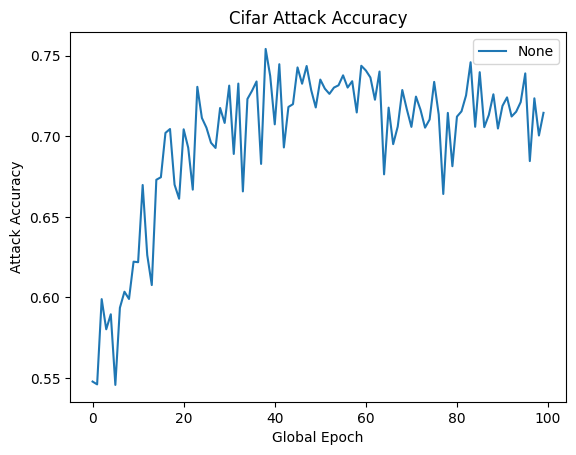

In [9]:
plt.figure()
plt.ylabel('Attack Accuracy')
plt.xlabel('Global Epoch')
plt.plot(range(len(sec_record)), sec_record, label='{}'.format(mechanism))
plt.title('{} Attack Accuracy'.format('Cifar'))
plt.legend()
plt.savefig('attack_acc.png')

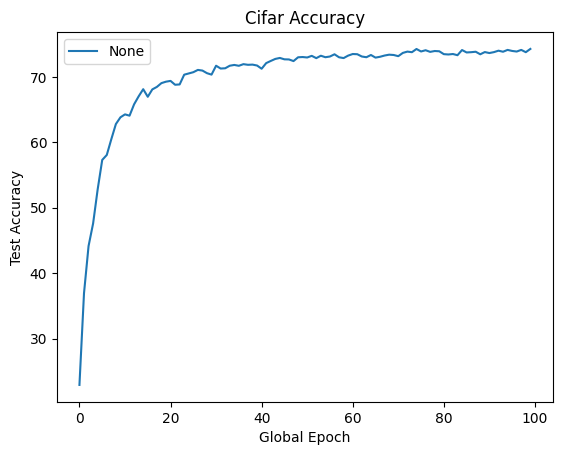

In [10]:
plt.figure()
plt.ylabel('Test Accuracy')
plt.xlabel('Global Epoch')
plt.plot(range(len(acc_record)), acc_record, label='{}'.format(mechanism))
plt.title('{} Accuracy'.format('Cifar'))
plt.legend()
plt.savefig('acc.png')

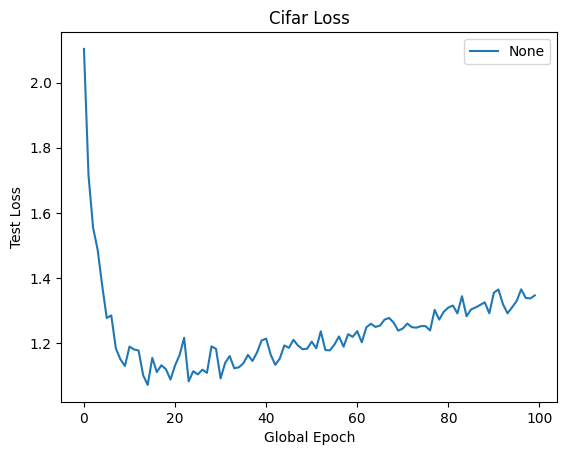

In [11]:
plt.figure()
plt.ylabel('Test Loss')
plt.xlabel('Global Epoch')
plt.plot(range(len(loss_record)), loss_record, label='{}'.format(mechanism))
plt.title('{} Loss'.format('Cifar'))
plt.legend()
plt.savefig('loss.png')

In [12]:
if not os.path.exists(rootpath):
    os.makedirs(rootpath)

accfile = open(rootpath + '/acc_{}_{}_{}_dp_{}_epsilon_{}_drop_{}dat'.
                    format('cifar', model_name, glob_epochs,
                    mechanism, eps, drop_frac), "w")
lossfile = open(rootpath + '/loss_{}_{}_{}_dp_{}_epsilon_{}_drop_{}.dat'.
                    format('cifar', model_name, glob_epochs,
                    mechanism, eps, drop_frac), "w")
secfile = open(rootpath + '/sec_{}_{}_{}_dp_{}_epsilon_{}_drop_{}.dat'.
                    format('cifar', model_name, glob_epochs,
                    mechanism, eps, drop_frac), "w")

tac = str(sum(time_record)) # write execution time in first line of accfile
accfile.write(tac)
accfile.write('\n')
for ac in acc_record:
    sac = str(ac)
    accfile.write(sac)
    accfile.write('\n')
accfile.close()

for lo in loss_record:
    slo = str(lo)
    lossfile.write(slo)
    lossfile.write('\n')
lossfile.close()

for se in sec_record:
    sse = str(se)
    secfile.write(sse)
    secfile.write('\n')
secfile.close()